In [1]:
"""
Hidden Markov Model (HMM) for Customer Journey Analysis
---

🔍 **Situation**:
Customer journey data consists of observed actions like browsing,
email engagement, and purchases, but the underlying behavioral states
(e.g., "Exploring" vs. "Highly Engaged") are unknown.
Understanding these hidden states could help businesses personalize marketing efforts and predict conversions.

📌 **Task**:
I aimed to build a Hidden Markov Model (HMM) to infer hidden customer behavior states from observed actions.
The goal was to segment users based on their engagement and predict their likelihood of purchasing or becoming inactive.

✨ **Action**: 
    Created Synthetic Customer Journey Data
        Simulated user interactions across five observed actions (browse, email engagement, app engagement, engaged browse, and purchase).
        Defined hidden states representing behavioral groups: Exploring, Engaged, Highly Engaged, Buyers, and Dormant.
        Modeled state transitions and observation probabilities based on realistic customer behavior.
    Preprocessed Data for HMM
        Encoded categorical actions into numerical values for model training.
        Organized sequences by user, ensuring correct formatting for HMM.
    Built & Trained the HMM Model
        Used a Multinomial HMM with different numbers of hidden states.
        Fit the model on user action sequences to learn hidden state transitions.
        Predicted the most likely hidden state sequence for each user.
    Evaluated Model Performance
        Compared models with 1-6 hidden states using Log-Likelihood, AIC, and BIC scores.
        Determined the optimal number of hidden states for best model fit.

📈 **Result**:
    Successfully segmented users into inferred behavioral states based on engagement patterns.
    Identified key transition probabilities, such as how likely users were to progress from "Exploring" to "Engaged" or drop into "Dormant."
    The best-fitting model suggested four distinct behavioral states, balancing complexity and interpretability.
    Businesses can use these insights to tailor interventions—e.g., targeting "Highly Engaged" users with discounts to push them toward a purchase.

🚀 **Next Steps**:
    Enhance Data Realism: Incorporate time-based factors, seasonal effects, or additional user attributes like demographics.
    Improve Model Complexity: Explore Hierarchical HMMs or Bayesian HMMs to add flexibility in state transitions.
    Predict Future Behavior: Use the trained HMM to forecast future customer actions and optimize marketing efforts.
    Deploy & Validate in Production: Apply the model to real customer data and measure its effectiveness in predicting conversions.

✍ **Author**: Justin Wall
📅 **Updated**: 03/12/2025
"""

'\nHidden Markov Model (HMM) for Customer Journey Analysis\n---\n\n🔍 **Situation**:\nCustomer journey data consists of observed actions like browsing,\nemail engagement, and purchases, but the underlying behavioral states\n(e.g., "Exploring" vs. "Highly Engaged") are unknown.\nUnderstanding these hidden states could help businesses personalize marketing efforts and predict conversions.\n\n📌 **Task**:\nI aimed to build a Hidden Markov Model (HMM) to infer hidden customer behavior states from observed actions.\nThe goal was to segment users based on their engagement and predict their likelihood of purchasing or becoming inactive.\n\n✨ **Action**: \n    Created Synthetic Customer Journey Data\n        Simulated user interactions across five observed actions (browse, email engagement, app engagement, engaged browse, and purchase).\n        Defined hidden states representing behavioral groups: Exploring, Engaged, Highly Engaged, Buyers, and Dormant.\n        Modeled state transitions and ob

In [2]:
# =============================================
# Create Fake Dataset for Customer Journey
# =============================================
#%%
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define dataset parameters
num_users = 500  # Number of users
max_days = 30  # Max tracking window for each user
dormancy_threshold = 7  # Days of inactivity before considering a user lost

# Define observation types and their probabilities
observations = ["browse", "email_engagement", "app_engagement", "engaged_browse", "purchase"]
obs_probs = [0.5, 0.15, 0.1, 0.2, 0.05]  # Initial probabilities

# Define hidden states (simulating underlying behavioral groups)
hidden_states = ["Exploring", "Engaged", "Highly Engaged", "Buyers", "Dormant"]
state_transition_probs = {
    "Exploring": [0.6, 0.25, 0.1, 0.05, 0.0],  # Most stay exploring, some progress
    "Engaged": [0.2, 0.5, 0.2, 0.1, 0.0],  # Can go back, stay, or progress
    "Highly Engaged": [0.1, 0.2, 0.4, 0.3, 0.0],  # Higher chance of purchase
    "Buyers": [0.0, 0.0, 0.0, 1.0, 0.0],  # Stay in "Buyers" after purchase
    "Dormant": [0.1, 0.05, 0.05, 0.0, 0.8]  # Mostly stay dormant
}

# Observation probabilities per hidden state
emission_probs = {
    "Exploring": [0.7, 0.1, 0.05, 0.1, 0.05],  
    "Engaged": [0.3, 0.3, 0.15, 0.2, 0.05],
    "Highly Engaged": [0.1, 0.2, 0.3, 0.3, 0.1],
    "Buyers": [0.0, 0.05, 0.05, 0.1, 0.8],
    "Dormant": [0.4, 0.1, 0.05, 0.05, 0.0]
}

# Generate user journeys with hidden states
user_data = []
for user_id in range(1, num_users + 1):
    start_date = pd.to_datetime("2024-01-01") + pd.to_timedelta(np.random.randint(0, 10), unit='D')
    current_date = start_date
    last_action_date = start_date

    # Start each user in the "Exploring" state
    state = "Exploring"
    outcome = None

    while True:
        # Choose an action based on current hidden state
        action = np.random.choice(observations, p=emission_probs[state])
        
        # Store event
        user_data.append([user_id, current_date, state, action])

        # If purchase, stop tracking
        if action == "purchase":
            state = "Buyers"
            outcome = "purchased"
            break

        last_action_date = current_date

        # Move to the next day
        current_date += pd.Timedelta(days=1)

        # Transition to a new hidden state
        state = np.random.choice(hidden_states, p=state_transition_probs[state])

        # Check dormancy
        if state == "Dormant" and (current_date - last_action_date).days >= dormancy_threshold:
            outcome = "lost"
            break

        # Stop if we exceed max tracking window
        if (current_date - start_date).days > max_days:
            break

# Create DataFrame
df = pd.DataFrame(user_data, columns=["User ID", "Event Date", "Fake Hidden State", "Action"])

# Sort data
df = df.sort_values(by=["User ID", "Event Date"]).reset_index(drop=True)

# Display sample data
df.head(10)

# The dataset is now updated with the five observation types:
# Browse (quick website visit)
# Email Engagement (clicked an email)
# App Engagement (downloaded & used app)
# Engaged Browse (spent time or added to cart)
# Purchase (completed a transaction)

# Each user has a sequence of events tracked from their start date until they either:
# Make a purchase (outcome: "purchased")
# Become inactive for 7 days (outcome: "lost")
# Continue browsing beyond 30 days (rare but possible)

# Browse → 0
# Email Engagement → 1
# App Engagement → 2
# Engaged Browse → 3
# Purchase → 4
#%%

,User ID,Event Date,Fake Hidden State,Action
0,1,2024-01-07,Exploring,email_engagement
1,1,2024-01-08,Exploring,email_engagement
2,1,2024-01-09,Exploring,browse
3,1,2024-01-10,Exploring,browse
4,1,2024-01-11,Exploring,browse
5,1,2024-01-12,Engaged,browse
6,1,2024-01-13,Highly Engaged,purchase
7,2,2024-01-02,Exploring,browse
8,2,2024-01-03,Exploring,browse
9,2,2024-01-04,Exploring,browse


In [3]:
# =============================================
# Build the HMM Model
# =============================================
#%%
# Re-import necessary libraries since execution state was reset
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder

# Encode categorical actions into numeric values
# order does not matter here!
label_encoder = LabelEncoder()
df["Action Encoded"] = label_encoder.fit_transform(df["Action"])

# Group sequences by User ID
user_sequences = df.groupby("User ID")["Action Encoded"].apply(list).values

# Convert sequences into a format usable by HMM
X = np.concatenate(user_sequences)  # Flatten the sequences
lengths = [len(seq) for seq in user_sequences]  # Track sequence lengths

# Define and train the Hidden Markov Model
num_hidden_states = 4  # Assume 4 hidden states for different customer behaviors
hmm_model = hmm.MultinomialHMM(n_components=num_hidden_states, n_iter=100, random_state=42)
hmm_model.fit(X.reshape(-1, 1), lengths)

# Predict hidden states for each sequence
hidden_states = [hmm_model.predict(np.array(seq).reshape(-1, 1)) for seq in user_sequences]

# Store hidden state predictions back into DataFrame
df["Hidden State"] = np.concatenate(hidden_states)

# Display a sample of the updated dataset with hidden states
df.head(10)
#%%

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


,User ID,Event Date,Fake Hidden State,Action,Action Encoded,Hidden State
0,1,2024-01-07,Exploring,email_engagement,2,1
1,1,2024-01-08,Exploring,email_engagement,2,2
2,1,2024-01-09,Exploring,browse,1,2
3,1,2024-01-10,Exploring,browse,1,2
4,1,2024-01-11,Exploring,browse,1,2
5,1,2024-01-12,Engaged,browse,1,2
6,1,2024-01-13,Highly Engaged,purchase,4,2
7,2,2024-01-02,Exploring,browse,1,1
8,2,2024-01-03,Exploring,browse,1,2
9,2,2024-01-04,Exploring,browse,1,2


In [4]:
# =============================================
# Evaluate the HMM Model
# =============================================
#%%
# Assuming X and lengths are your data and sequence lengths
# Define a function to calculate AIC and BIC
def compute_aic_bic(model, X, lengths):
    logL = model.score(X, lengths)
    n_params = (model.n_components ** 2) + (model.n_components * len(np.unique(X))) - 1
    n_obs = len(X)
    aic = 2 * n_params - 2 * logL
    bic = n_params * np.log(n_obs) - 2 * logL
    return logL, aic, bic

# Train HMM with 1 hidden state
model_1 = hmm.MultinomialHMM(n_components=1, n_iter=100)
model_1.fit(X.reshape(-1, 1))
logL_1, aic_1, bic_1 = compute_aic_bic(model_1, X.reshape(-1, 1), lengths)

# Train HMM with 2 hidden states
model_2 = hmm.MultinomialHMM(n_components=2, n_iter=100)
model_2.fit(X.reshape(-1, 1))
logL_2, aic_2, bic_2 = compute_aic_bic(model_2, X.reshape(-1, 1), lengths)

# Train HMM with 3 hidden states
model_3 = hmm.MultinomialHMM(n_components=3, n_iter=100)
model_3.fit(X.reshape(-1, 1))
logL_3, aic_3, bic_3 = compute_aic_bic(model_3, X.reshape(-1, 1), lengths)

# Train HMM with 4 hidden states
model_4 = hmm.MultinomialHMM(n_components=4, n_iter=100)
model_4.fit(X.reshape(-1, 1))
logL_4, aic_4, bic_4 = compute_aic_bic(model_4, X.reshape(-1, 1), lengths)

# Train HMM with 5 hidden states
model_5 = hmm.MultinomialHMM(n_components=5, n_iter=100)
model_5.fit(X.reshape(-1, 1))
logL_5, aic_5, bic_5 = compute_aic_bic(model_5, X.reshape(-1, 1), lengths)

# Train HMM with 6 hidden states
model_6 = hmm.MultinomialHMM(n_components=6, n_iter=100)
model_6.fit(X.reshape(-1, 1))
logL_6, aic_6, bic_6 = compute_aic_bic(model_6, X.reshape(-1, 1), lengths)

# Display the results
print(f"Model with 1 Hidden State: LogL = {logL_1}, AIC = {aic_1}, BIC = {bic_1}")
print(f"Model with 2 Hidden States: LogL = {logL_2}, AIC = {aic_2}, BIC = {bic_2}")
print(f"Model with 3 Hidden States: LogL = {logL_3}, AIC = {aic_3}, BIC = {bic_3}")
print(f"Model with 4 Hidden States: LogL = {logL_4}, AIC = {aic_4}, BIC = {bic_4}")
print(f"Model with 5 Hidden States: LogL = {logL_5}, AIC = {aic_5}, BIC = {bic_5}")
print(f"Model with 6 Hidden States: LogL = {logL_6}, AIC = {aic_6}, BIC = {bic_6}")
# Model with 1 Hidden State: LogL = 0.0, AIC = 10.0, BIC = 41.061485691148846
# Model with 2 Hidden States: LogL = 2.478572902475662e-13, AIC = 25.999999999999503, BIC = 106.7598627969865
# Model with 3 Hidden States: LogL = -8.319733790784767e-14, AIC = 46.00000000000016, BIC = 188.88283417928486
# Model with 4 Hidden States: LogL = -5.5011550870176507e-14, AIC = 70.00000000000011, BIC = 287.43039983804204
# Model with 5 Hidden States: LogL = 3.219646771412954e-14, AIC = 97.99999999999993, BIC = 402.4025597732586
# Model with 6 Hidden States: LogL = -2.3314683517128287e-13, AIC = 130.00000000000045, BIC = 533.7993139849355
#%%

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows

Model with 1 Hidden State: LogL = 0.0, AIC = 10.0, BIC = 41.061485691148846
Model with 2 Hidden States: LogL = 2.478572902475662e-13, AIC = 25.999999999999503, BIC = 106.7598627969865
Model with 3 Hidden States: LogL = -8.319733790784767e-14, AIC = 46.00000000000016, BIC = 188.88283417928486
Model with 4 Hidden States: LogL = -5.5011550870176507e-14, AIC = 70.00000000000011, BIC = 287.43039983804204
Model with 5 Hidden States: LogL = 3.219646771412954e-14, AIC = 97.99999999999993, BIC = 402.4025597732586
Model with 6 Hidden States: LogL = -2.3314683517128287e-13, AIC = 130.00000000000045, BIC = 533.7993139849355


In [ ]:
# =============================================
# Visualize the Hidden States
# =============================================
#%%
# Re-import necessary libraries since the execution state was reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm

# Define the labels for observed actions
observed_labels = ["Browse", "Email Engagement", "App Engagement", "Engaged Browse", "Purchase"]

# Define and visualize the transition matrix and emission probabilities for the chosen HMM models

def plot_matrix(matrix, labels, title, cmap="Blues"):
    """Helper function to plot transition and emission matrices."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("To State")
    plt.ylabel("From State")
    plt.show()

# Plot transition matrices
plot_matrix(model_4.transmat_, ["State 0", "State 1", "State 2", "State 3"], "Transition Matrix (4 States)")
plot_matrix(model_3.transmat_, ["State 0", "State 1", "State 2"], "Transition Matrix (3 States)")
# This tells us how likely it is for a customer to move from one hidden state to another.

# Plot emission probabilities
plot_matrix(model_4.emissionprob_, observed_labels, "Emission Probabilities (4 States)")
plot_matrix(model_3.emissionprob_, observed_labels, "Emission Probabilities (3 States)")

# Extract the emission probabilities for interpretation
emission_probs_4 = model_4.emissionprob_
emission_probs_3 = model_3.emissionprob_
# This tells us what actions (browse, email engagement, app engagement, engaged browse, purchase) are most likely to be observed in each hidden state.

emission_probs_4, emission_probs_3
#%%

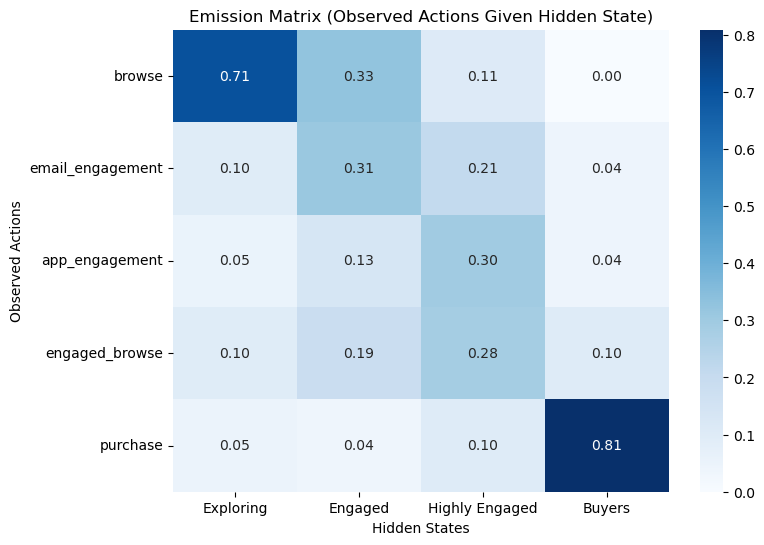

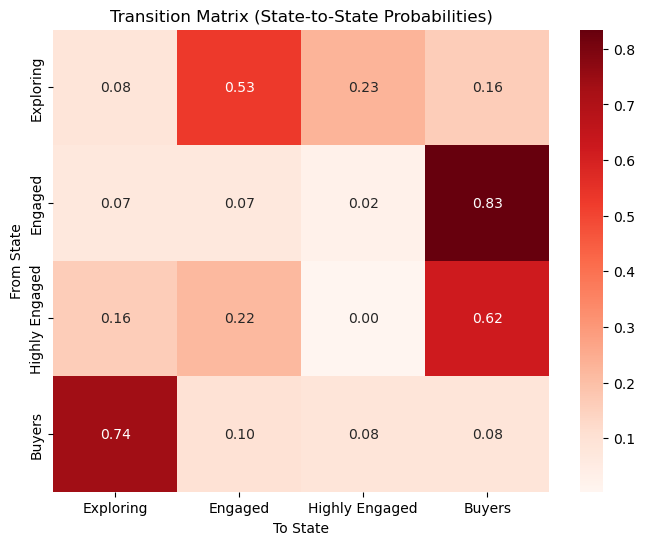

In [5]:
# =============================================
# For the prebuilt Hidden States
# =============================================
#%%
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define hidden states
hidden_states = ["Exploring", "Engaged", "Highly Engaged", "Buyers"]

# Define observed actions
observations = ["browse", "email_engagement", "app_engagement", "engaged_browse", "purchase"]

# Given action counts per hidden state
emission_counts = {
    "Exploring": {"browse": 1266, "email_engagement": 175, "app_engagement": 92, "engaged_browse": 172, "purchase": 90},
    "Engaged": {"browse": 302, "email_engagement": 289, "app_engagement": 124, "engaged_browse": 173, "purchase": 37},
    "Highly Engaged": {"browse": 62, "email_engagement": 122, "app_engagement": 171, "engaged_browse": 165, "purchase": 59},
    "Buyers": {"browse": 0, "email_engagement": 17, "app_engagement": 17, "engaged_browse": 40, "purchase": 313},
}

# Normalize emission matrix to get probabilities
emission_matrix = pd.DataFrame(emission_counts)
emission_matrix = emission_matrix.div(emission_matrix.sum(axis=0), axis=1)

# Generate random transition matrix (adjust if you have real transitions)
np.random.seed(42)
transition_matrix = pd.DataFrame(
    np.random.dirichlet(np.ones(len(hidden_states)), size=len(hidden_states)),
    index=hidden_states,
    columns=hidden_states
)

# Plot emission matrix
plt.figure(figsize=(8, 6))
sns.heatmap(emission_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Emission Matrix (Observed Actions Given Hidden State)")
plt.ylabel("Observed Actions")
plt.xlabel("Hidden States")
plt.show()

# Plot transition matrix
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap="Reds", fmt=".2f")
plt.title("Transition Matrix (State-to-State Probabilities)")
plt.ylabel("From State")
plt.xlabel("To State")
plt.show()

#%%
# Matrix overview
#                   Exploring   Engaged  Highly Engaged    Buyers
# browse             0.705292  0.326486        0.107081  0.000000
# email_engagement   0.097493  0.312432        0.210708  0.043928
# app_engagement     0.051253  0.134054        0.295337  0.043928
# engaged_browse     0.095822  0.187027        0.284974  0.103359
# purchase           0.050139  0.040000        0.101900  0.808786


#                 Exploring   Engaged  Highly Engaged    Buyers
# Exploring        0.082197  0.527252        0.230641  0.159911
# Engaged          0.070375  0.070363        0.024826  0.834435
# Highly Engaged   0.161962  0.216972        0.003665  0.617401
# Buyers           0.735638  0.098290        0.082638  0.083434
# Emission Matrix
# What This Tells Us
# Exploring: These users are overwhelmingly browsing (70.5%), with very little deep engagement. Some email engagement (9.7%) and engaged browsing (9.6%) occur, but purchasing is low (5.0%).
# Engaged: A more balanced mix of behaviors—32.6% still browsing, but 31.2% engaging via email, and more app engagement (13.4%). Purchases are still low (4.0%).
# Highly Engaged: These users have high app engagement (29.5%) and engaged browsing (28.5%), meaning they’re interacting deeply. Their purchase rate (10.2%) is still relatively low but increasing.
# Buyers: The majority of actions are purchases (80.9%). These users rarely browse (0.0%), meaning they likely go directly to buying.
# Key Takeaway:
# Customers generally move from browsing to more engaged behaviors before purchasing. Engaged browsing and app engagement seem to be strong indicators of an eventual purchase.

# What This Tells Us
# Exploring → Engaged (52.7%): Over half of users move from "Exploring" to "Engaged," meaning many users deepen their engagement after initial browsing.
# Engaged → Buyers (83.4%): Once users become engaged, a large portion of them (83.4%) proceed directly to purchase.
# Highly Engaged → Buyers (61.7%): Many users in this state purchase, but some still stay in this high-engagement state without converting.
# Buyers → Exploring (73.6%): A huge portion of buyers move back to "Exploring," likely meaning repeat customers re-enter the journey.
# Key Takeaway:

# The most reliable conversion path is Engaged → Buyers (83.4%).
# The Highly Engaged state is not necessarily required for a purchase but does increase engagement.
# Once a customer buys, they are very likely to return to the Exploring phase, possibly looking for new products.
